<a href="https://colab.research.google.com/github/neuromatch/course-content-template/blob/main/tutorials/W1D2_Template/W1D2_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/course-content-template/main/tutorials/W1D2_Template/W1D2_Tutorial1.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Tutorial 5: Replay

**Week 2, Day 4: Macro-Learning**

**By Neuromatch Academy**

__Content creators:__ Hlib Solodzhuk, Ximeng Mao, Grace Lindsay

__Content reviewers:__ Names & Surnames

__Production editors:__ Names & Surnames

<br>

Acknowledgments: [ACKNOWLEDGMENT_INFORMATION]

___


# Tutorial Objectives

*Estimated timing of tutorial: 40 minutes*

In this tutorial, you will discover what replay is and how it helps with continual learning.

In [1]:
# @title Tutorial slides

# @markdown These are the slides for the videos in all tutorials today


## Uncomment the code below to test your function

#from IPython.display import IFrame
#link_id = "<YOUR_LINK_ID_HERE>"

# print("If you want to download the slides: 'Link to the slides'")
      # Example: https://osf.io/download/{link_id}/

#IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{link_id}/?direct%26mode=render", width=854, height=480)

---
# Setup



In [2]:
# @title Install and import feedback gadget

# !pip3 install vibecheck datatops --quiet

# from vibecheck import DatatopsContentReviewContainer
# def content_review(notebook_section: str):
#     return DatatopsContentReviewContainer(
#         "",  # No text prompt - leave this as is
#         notebook_section,
#         {
#             "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
#             "name": "sciencematch_sm", # change the name of the course : neuromatch_dl, climatematch_ct, etc
#             "user_key": "y1x3mpx5",
#         },
#     ).render()

# feedback_prefix = "W2D4_T5"

In [3]:
# Imports

#working with data
import numpy as np
import random

#plotting
import matplotlib.pyplot as plt
import logging
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

#interactive display
import ipywidgets as widgets

#modeling
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [4]:
# @title Figure settings

logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perfrom high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [5]:
# @title Plotting functions

def plot_rewards(rewards, max_rewards):
    """
    Plot the rewards over time.

    Inputs:
    - rewards (list): list containing the rewards at each time step.
    - max_rewards(list): list containing the maximum rewards at each time step.
    """
    with plt.xkcd():
        plt.plot(range(len(rewards)), rewards, marker='o', label = "Obtained Reward")
        plt.plot(range(len(max_rewards)), max_rewards, marker='*', label = "Maximum Reward")
        plt.xlabel('Time Step')
        plt.ylabel('Reward Value')
        plt.title('Reward Over Time')
        plt.yticks(np.arange(0, 5, 1))
        plt.xticks(np.arange(0, len(rewards), 1))
        plt.legend()
        plt.show()

def plot_confusion_matrix(rewards, max_rewards, mode = 1):
    """
    Plots the confusion matrix for the chosen rewards and the maximum ones.

    Inputs:
    - rewards (list): list containing the rewards at each time step.
    - max_rewards (list): list containing the maximum rewards at each time step.
    - mode (int, default = 1): mode of the environment.
    """
    with plt.xkcd():

      all_colors = [color for color in mode_colors[mode]]

      cm = confusion_matrix(max_rewards, rewards)

      missing_classes = np.setdiff1d(np.array([color_names_rewards[color_name] for color_name in all_colors]), np.unique(max_rewards + rewards))
      for cls in missing_classes:
          cm = np.insert(cm, cls - 1, 0, axis=0)
          cm = np.insert(cm, cls - 1, 0, axis=1)

      cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = all_colors)
      cm.plot()
      plt.xlabel("Chosen color")
      plt.ylabel("Maximum-reward color")
      plt.show()

In [6]:
# @title Helper functions

def run_dummy_agent(env):
    """
    Implement dummy agent strategy: chooses random action.

    Inputs:
    - env (ChangingEnv): An environment.
    """
    action = 0
    rewards = [0]
    max_rewards = [0]

    for _ in (range(num_trials)):
        _, reward, max_reward = env.step(action)
        rewards.append(reward)
        max_rewards.append(max_reward)

        #dummy agent
        if np.random.random() < 0.5:
            action = 1 - action #change action
    return rewards, max_rewards

In [7]:
# @title Data retrieval

import os
import requests
import hashlib

# Variables for file and download URL
fnames = ["FirstModeAgent.pt", "SecondModeAgent.pt"] # The names of the files to be downloaded
urls = ["https://osf.io/zuxc4/download", "https://osf.io/j9kht/download"] # URLs from where the files will be downloaded
expected_md5s = ["eca5aa69751dad8ca06742c819f2dc76", "cdd0338d0b40ade20d6433cd615aaa82"] # MD5 hashes for verifying files integrity

for fname, url, expected_md5 in zip(fnames, urls, expected_md5s):
    if not os.path.isfile(fname):
        try:
            # Attempt to download the file
            r = requests.get(url) # Make a GET request to the specified URL
        except requests.ConnectionError:
            # Handle connection errors during the download
            print("!!! Failed to download data !!!")
        else:
            # No connection errors, proceed to check the response
            if r.status_code != requests.codes.ok:
                # Check if the HTTP response status code indicates a successful download
                print("!!! Failed to download data !!!")
            elif hashlib.md5(r.content).hexdigest() != expected_md5:
                # Verify the integrity of the downloaded file using MD5 checksum
                print("!!! Data download appears corrupted !!!")
            else:
                # If download is successful and data is not corrupted, save the file
                with open(fname, "wb") as fid:
                    fid.write(r.content) # Write the downloaded content to a file

In [8]:
# @title Set device (GPU or CPU).

def set_device():
    """
    Determines and sets the computational device for PyTorch operations based on the availability of a CUDA-capable GPU.

    Outputs:
    - device (str): The device that PyTorch will use for computations ('cuda' or 'cpu'). This string can be directly used
    in PyTorch operations to specify the device.
    """

    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device != "cuda":
        print("GPU is not enabled in this notebook. \n"
              "If you want to enable it, in the menu under `Runtime` -> \n"
              "`Hardware accelerator.` and select `GPU` from the dropdown menu")
    else:
        print("GPU is enabled in this notebook. \n"
              "If you want to disable it, in the menu under `Runtime` -> \n"
              "`Hardware accelerator.` and select `None` from the dropdown menu")

    return device

device = set_device()

GPU is not enabled in this notebook. 
If you want to enable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `GPU` from the dropdown menu


In [9]:
# @title Set random seed

import random
import numpy as np
import torch

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(seed = 42)

In [10]:
# @title Video 1: Replay

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

# video_ids = [('Youtube', '<video_id_1>'), ('Bilibili', '<video_id_2>'), ('Osf', '<video_id_3>')]
# tab_contents = display_videos(video_ids, W=854, H=480)
# tabs = widgets.Tab()
# tabs.children = tab_contents
# for i in range(len(tab_contents)):
#   tabs.set_title(i, video_ids[i][0])
# display(tabs)

In [ ]:
# @title Submit your feedback
# content_review(f"{feedback_prefix}_replay")

---

# Section 1: Changing Environment

As mentioned in the video, to study replay we need to use a slightly different task that is inspired by the Harlow task, but creates an incentive to remember past data. In this section we will introduce this new task environment.

## Coding Exercise 1: Colorful State

For this tutorial, each state will be represented by its color (via its RGB values; thus, it is vector of 3 values) and each color is associated with a stable reward that is unchanged over time (the rewards will correspond to the position of the color in the rainbow).

While the reward associated with each color does not change over time, the colors presented to the agent will change. Specifically, on each trial, the agent is presented two colors and should choose the one associated with higher reward. Initially (in 'mode 1'), colors will be chosen from a set of 3 possible colors. Over time, one of these colors will be replaced by another creating a different set of three possible colors ('mode 2'). This constitutes a distribution shift, and may cause the agent to forget the reward associated with the dropped color. 

For this exercise, you should complete missing parts of the enviornment. You may like to inspect the helpful lists and dictionaries in the cell below.

In [11]:
color_names_rewards = {
    "red": 1,
    "yellow": 2,
    "green": 3,
    "blue": 4
}

color_names_values = {
    "red": [255, 0, 0],
    "yellow": [255, 255, 0],
    "green": [0, 128, 0],
    "blue": [0, 0, 255]
}

first_mode = ["red", "yellow", "green"]
second_mode = ["red", "green", "blue"]

mode_colors = {
    1: first_mode,
    2: second_mode
}

In [12]:
class ChangingEnv():
    def __init__(self, mode = 1):
        """Initialize changing environment.

        Inputs:
        - mode (int, default = 1): defines mode of the enviornment. Should be only 1 or 2.
        """
        if mode not in [1, 2]:
            raise ValueError("Mode is out of allowed range. Please consider entering 1 or 2 as digit.")

        self.mode = mode
        self.colors = mode_colors[self.mode]
        self.update_state()

    def update_state(self):
        """Update state which depends on the mode of the environment."""
        ###################################################################
        ## Fill out the following then remove
        raise NotImplementedError("Student exercise: complete state update and choose appropriate feedback.")
        ###################################################################

        self.first_color, self.second_color = np.random.choice(..., 2, replace = False)
        self.color_state = np.array([self.first_color, self.second_color])
        self.state = np.array([color_names_values[...], color_names_values[...]])

    def reset(self, mode = 1):
        """Reset environment by updating its mode (colors to sample from). Set the first state in the given mode."""
        self.mode = mode
        self.colors = mode_colors[self.mode]
        self.update_state()
        return self.state

    def step(self, action):
        """Evaluate agent's perfromance, return reward, max reward (for tracking agent's performance) and next observation."""
        feedback = color_names_rewards[self.color_state[...]]
        max_feedback = np.max([..., ...])
        self.update_state()
        return self.state, feedback, max_feedback

In [13]:
# to_remove solution

class ChangingEnv():
    def __init__(self, mode = 1):
        """Initialize changing environment.

        Inputs:
        - mode (int, default = 1): defines mode of the enviornment. Should be only 1 or 2.
        """
        if mode not in [1, 2]:
            raise ValueError("Mode is out of allowed range. Please consider entering 1 or 2 as digit.")

        self.mode = mode
        self.colors = mode_colors[self.mode]
        self.update_state()

    def update_state(self):
        """Update state which depends on the mode of the environment."""
        self.first_color, self.second_color = np.random.choice(self.colors, 2, replace = False)
        self.color_state = np.array([self.first_color, self.second_color])
        self.state = np.array([color_names_values[self.first_color], color_names_values[self.second_color]])

    def reset(self, mode = 1):
        """Reset environment by updating its mode (colors to sample from). Set the first state in the given mode."""
        self.mode = mode
        self.colors = mode_colors[self.mode]
        self.update_state()
        return self.state

    def step(self, action):
        """Evaluate agent's perfromance, return reward, max reward (for tracking agent's performance) and next observation."""
        feedback = color_names_rewards[self.color_state[action]]
        max_feedback = np.max([color_names_rewards[self.color_state[action]], color_names_rewards[self.color_state[1 - action]]])
        self.update_state()
        return self.state, feedback, max_feedback

As in previous tutorial, let us test the environment with a dummy agent. For this particular enviornment (in mode 1), we will use a random strategy - just select one of two colors by tossing a fair coin.

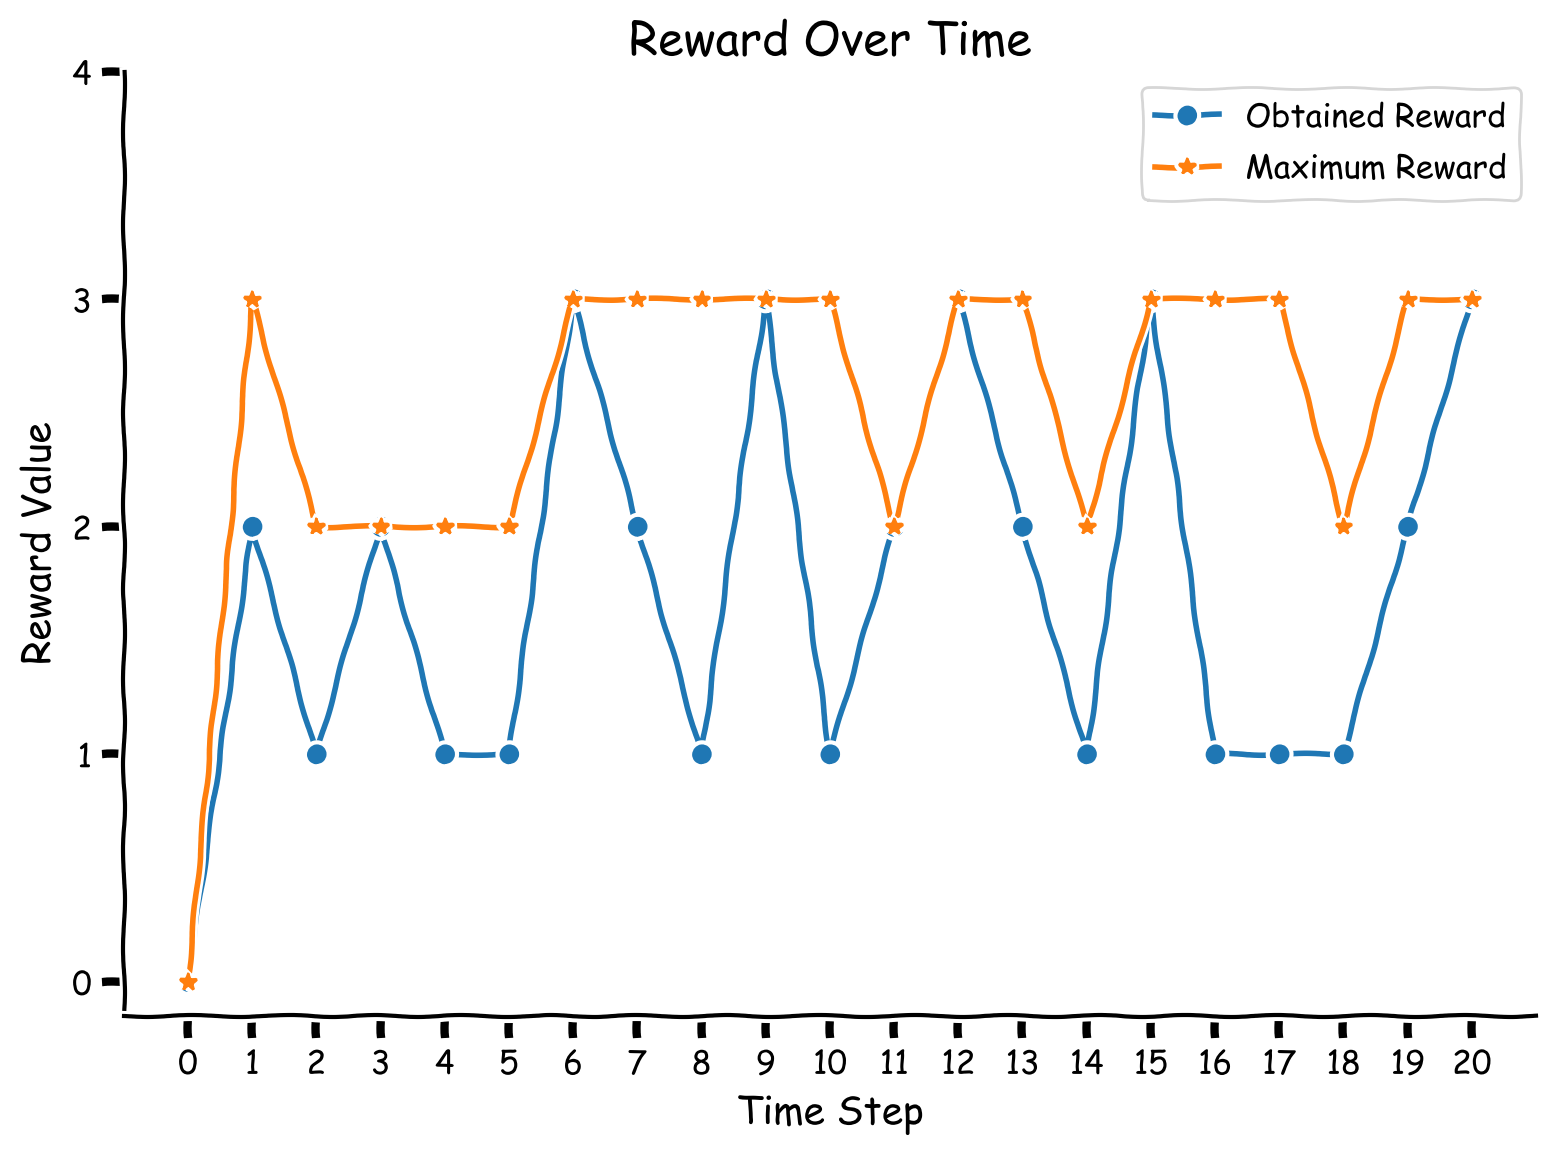

In [14]:
# @markdown Make sure you execute this cell to observe the plot!

set_seed(42)
num_trials = 20
env = ChangingEnv()
env.reset()
rewards, max_rewards = run_dummy_agent(env)

plot_rewards(rewards, max_rewards)

Observe that the maximum reward is always higher than obtained reward or coincides with it (when agent luckily chooses more rewarded color).

In [ ]:
# @title Submit your feedback
# content_review(f"{feedback_prefix}_colorful_state")

---

# Section 2: A2C Agent in Changing Environment

*Estimated timing to here from start of tutorial: 10 minutes*

Welcome the friend from the previous tutorial, the A2C agent ;) Here we slightly modify the architecture (with LSTM cells being replaced with 1 linear layer with ReLUs on top of it). The variable `num_inputs` is changed too as now input is represented by 3-dimensional vector and not a single digit. Moreover, we will make training and evaluation functions separate - as we don't have a "task" and "meta-space of tasks" notions here, we don't need to keep track of this.

In [20]:
class ActorCritic(nn.Module):
    def __init__(self, hidden_size, num_inputs = 9, num_actions = 2):
        """Initialize Actor-Critic agent."""
        super(ActorCritic, self).__init__()

        #num_actions is 2 because left/right hand
        self.num_actions = num_actions

        #num_inputs is 9 because one-hot encoding of action (2) + reward (1) + previous state (2*3 = 6)
        self.num_inputs = num_inputs

        self.hidden_size = hidden_size

        #hyperparameters involved in training (important to keep assigned to the agent)
        self.learning_rate = 0.00075 #learning rate for optimizer
        self.discount_factor = 0.91 #gamma
        self.state_value_estimate_cost = 0.4 #beta_v
        self.entropy_cost = 0.001 #beta_e

        self.emb = nn.Linear(num_inputs, hidden_size)
        self.linear1 = nn.Linear(hidden_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.critic_linear = nn.Linear(hidden_size, 1)
        self.actor_linear = nn.Linear(hidden_size, num_actions)

    def forward(self, state):
        """Implement forward pass through agent."""
        #at first, input goes through embedding
        state = F.linear(state.unsqueeze(0), self.emb.weight.clone(), self.emb.bias)
        state = self.relu1(F.linear(state, self.linear1.weight.clone(), self.linear1.bias))

        #critic -> value
        value = F.linear(state, self.critic_linear.weight.clone(), self.critic_linear.bias)

        #actor -> policy
        policy_logits = F.linear(state, self.actor_linear.weight.clone(), self.actor_linear.bias)

        return value, policy_logits

In the cell below we define the training procedure for the A2C agent as well as its evaluation.

In [19]:
def train_agent(env, agent, optimizer_func, mode = 1, num_gradient_steps = 1000, num_trials = 100):
    """Training for agent in changing colorful environment.
    Observe that training happens for one particular mode.

    Inputs:
    - env (ChangingEnv): environment.
    - agent (ActorCritic): particular instance of Actor Critic agent to train.
    - optimizer_func (torch.Optim): optimizer to use for training.
    - mode (int, default = 1): mode of the environment.
    - num_gradient_steps (int, default = 1000): number of gradient steps to perform.
    - num_trials (int, default = 200): number of times the agent is exposed to the environment per gradient step to be trained.
    """

    #reset environment
    state = env.reset(mode = mode)

    #define optimizer
    optimizer = optimizer_func(agent.parameters(), agent.learning_rate, eps = 1e-5)

    for _ in range(num_gradient_steps):

      #for storing variables for training
      log_probs = []
      values = []
      rewards = []
      entropy_term = torch.tensor(0.)

      #start conditions
      preceding_reward = torch.Tensor([0])
      preceding_action = torch.Tensor([0, 0])

      for trial in range(num_trials):
          #state + reward + one-hot encoding of action; notice that we normalize state before pass to agent!
          full_state = torch.cat((torch.from_numpy(state.flatten() / 255).float(), preceding_reward, preceding_action), dim = 0)
          value, policy_logits = agent(full_state)
          value = value.squeeze(0)

          #sample action from policy
          dist = torch.distributions.Categorical(logits=policy_logits.squeeze(0))
          action = dist.sample()

          #perform action to get reward and new state
          new_state, reward, _ = env.step(action)

          #we normalize reward too
          reward /= 4

          #update preceding variables
          preceding_reward = torch.Tensor([reward])
          preceding_action = F.one_hot(action, num_classes=2).float()
          state = new_state

          #for training
          log_prob = dist.log_prob(action)
          entropy = dist.entropy()
          rewards.append(reward)
          values.append(value)
          log_probs.append(log_prob)
          entropy_term += entropy

      #calculataing loss
      Qval = 0
      Qvals = torch.zeros(len(rewards))
      for t in reversed(range(len(rewards))):
        Qval = rewards[t] + agent.discount_factor * Qval
        Qvals[t] = Qval
      values = torch.stack(values)
      log_probs = torch.stack(log_probs)
      advantage = Qvals - values
      actor_loss = (-log_probs * advantage.detach()).mean()
      critic_loss = advantage.pow(2).mean()
      entropy_term = entropy_term / num_trials

      #loss incorporates actor/critic terms + entropy
      loss = actor_loss + agent.state_value_estimate_cost * critic_loss - agent.entropy_cost * entropy_term

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

def evaluate_agent(env, agent, mode = 1, num_evaluation_trials = 20):
    """Evaluation for agent in changing colorful environment.
    Observe that evaluation happens for one particular mode which can differ from training one.

    Inputs:
    - env (ChangingEnv): environment.
    - agent (ActorCritic): particular instance of Actor Critic agent to train.
    - mode (int, default = 1): mode of the environment.
    - num_evaluation_trials (int, default = 20): number of times the agent is exposed to the environment to evaluate it (no training happend during this phase).

    Outputs:
    - scores (list): rewards over all trials of evaluation.
    - max_scores (list): maximum rewards over all trials of evaluation.
    """
    #reset environment
    state = env.reset(mode = mode)
    scores = []
    max_scores = []

    #start conditions
    preceding_reward = torch.Tensor([0])
    preceding_action = torch.Tensor([0, 0])

    for _ in range(num_evaluation_trials):

      #state + reward + one-hot encoding of action; notice that we normalize state before pass to agent!
      full_state = torch.cat((torch.from_numpy(state.flatten() / 255).float(), preceding_reward, preceding_action), dim = 0)
      value, policy_logits = agent(full_state)
      value = value.squeeze(0)

      #sample action from policy
      dist = torch.distributions.Categorical(logits=policy_logits.squeeze(0))
      action = dist.sample()

      #perform action to get reward and new state
      new_state, reward, max_reward = env.step(action)

      #update preceding variables; we normalize reward too
      preceding_reward = torch.Tensor([reward / 4])
      preceding_action = F.one_hot(action, num_classes=2).float()
      state = new_state

      #add reward to the scores of agent
      scores.append(reward)
      max_scores.append(max_reward)

    return scores, max_scores

In the following code cell, let's observe the agent's performance on the first mode after being trained on it. As training of the agent takes around 3 minutes, we have provided you with an already trained version (still feel free to uncomment the training code to receive the same results). You will also have the opportunity to train the agent from scratch in the next section!

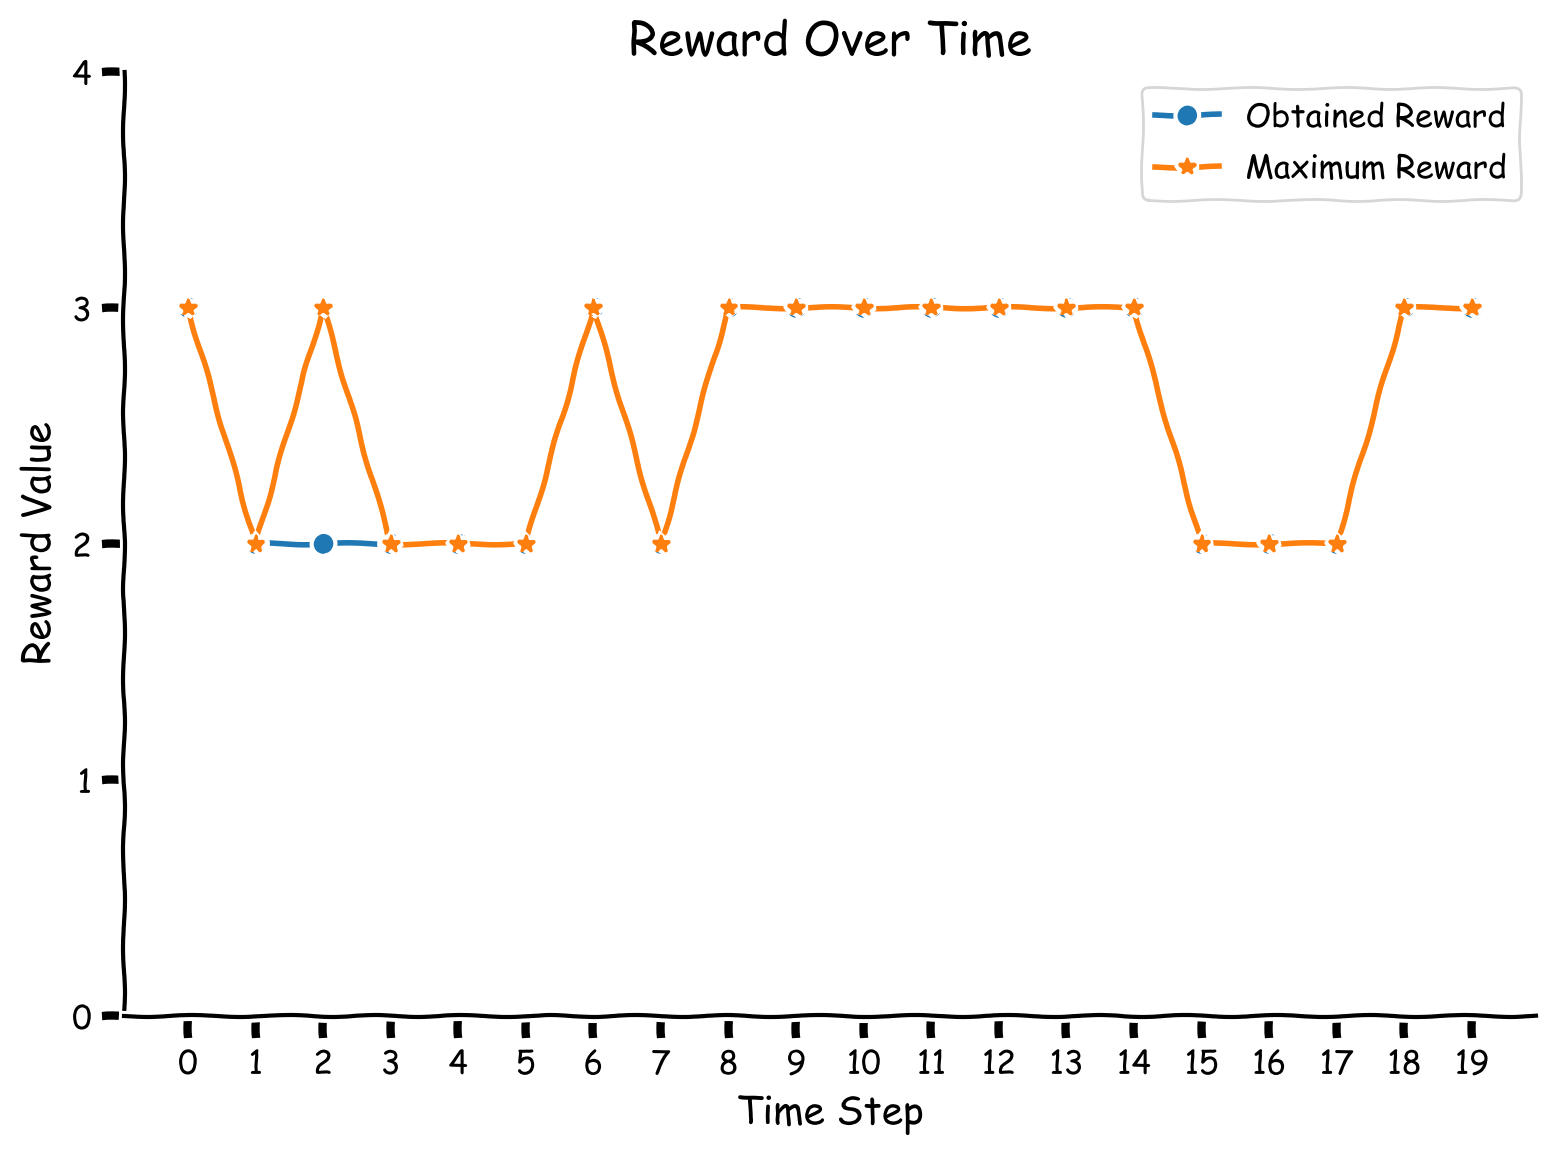

In [21]:
# @markdown Make sure you execute this cell to observe the plot!

set_seed(42)

#define environment
env = ChangingEnv()

#train agent
##UNCOMMENT TO TRAIN
# agent = ActorCritic(hidden_size = 100)
# optimizer_func = optim.RMSprop
# train_agent(env, agent, optimizer_func)
##UNCOMMENT TO TRAIN

#load agent
agent = torch.load("FirstModeAgent.pt")

#evaluate agent
rewards, max_rewards = evaluate_agent(env, agent)
plot_rewards(rewards, max_rewards)

Pretty nice! Let us also observe the confusion matrix. Indeed, it might reveal to us the weaknesses being incorporated in the particular colors. We will increase the number of evaluation trials to get the more statistically true results.

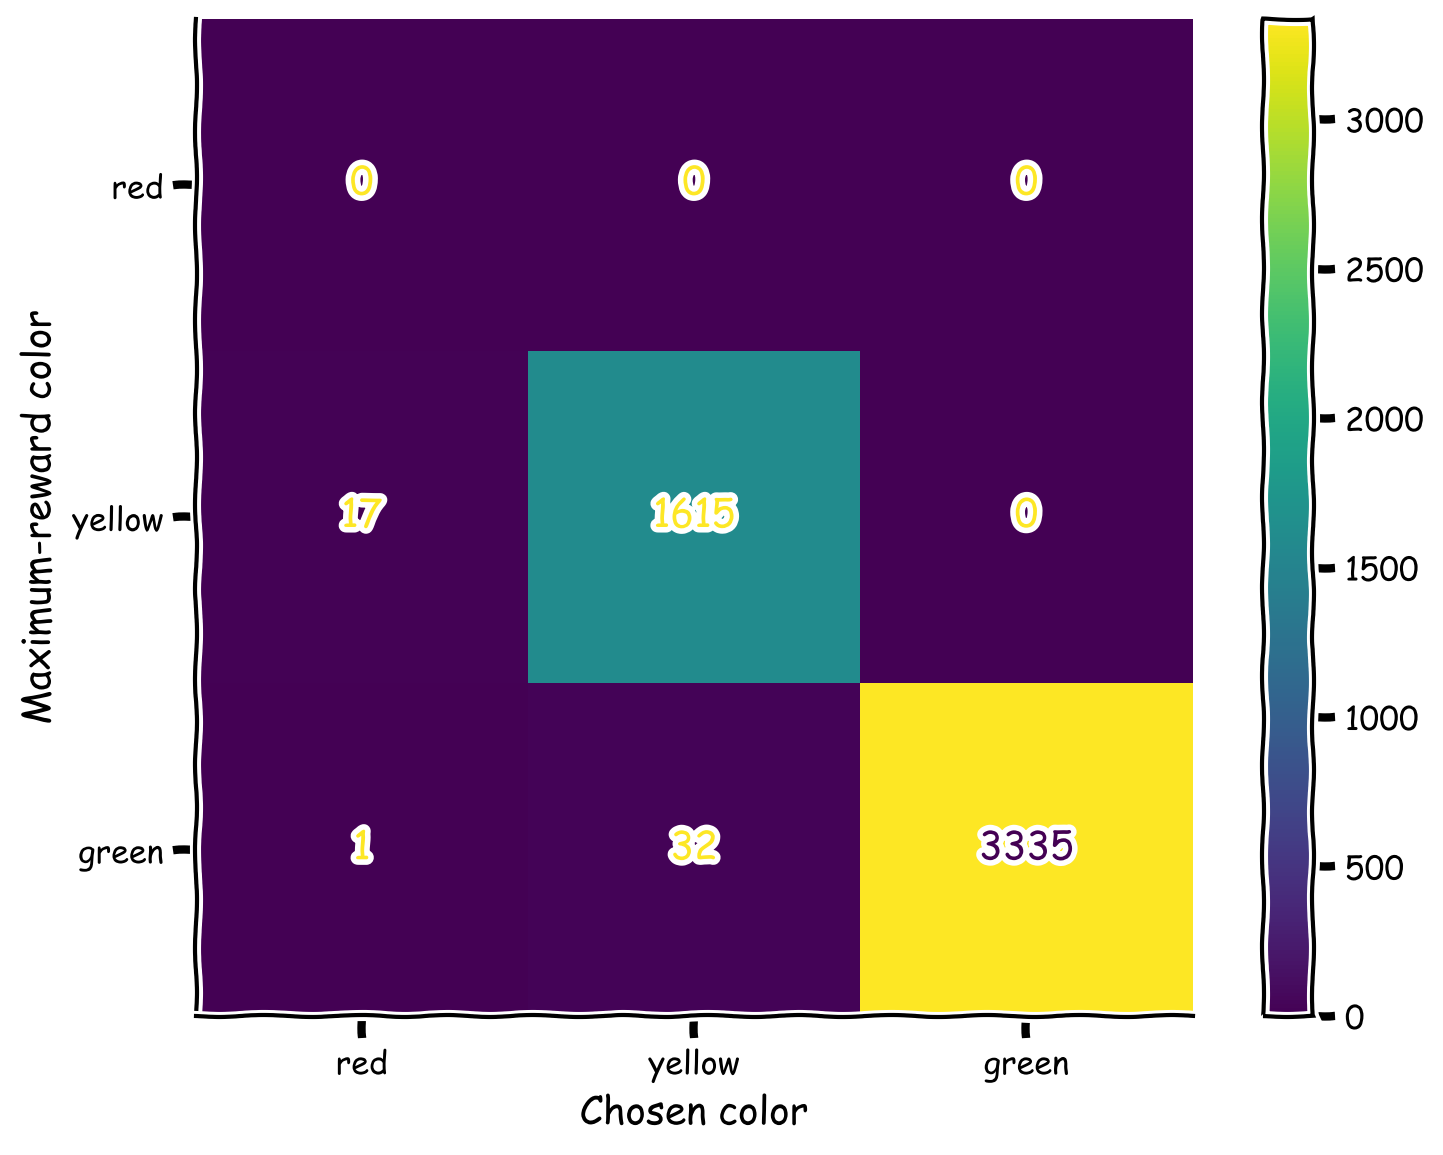

In [22]:
# @markdown Make sure you execute this cell to observe the plot!
set_seed(42)

rewards, max_rewards = evaluate_agent(env, agent, num_evaluation_trials = 5000)
plot_confusion_matrix(rewards, max_rewards)

No specific patterns here; the only thing (which is also expected) is that whenever colors are close in their rewards, the agent makes more mistakes for those.

Notice that the blue color is missing as it is indeed excluded from the first mode. Let us evaluate the agent on the second mode.

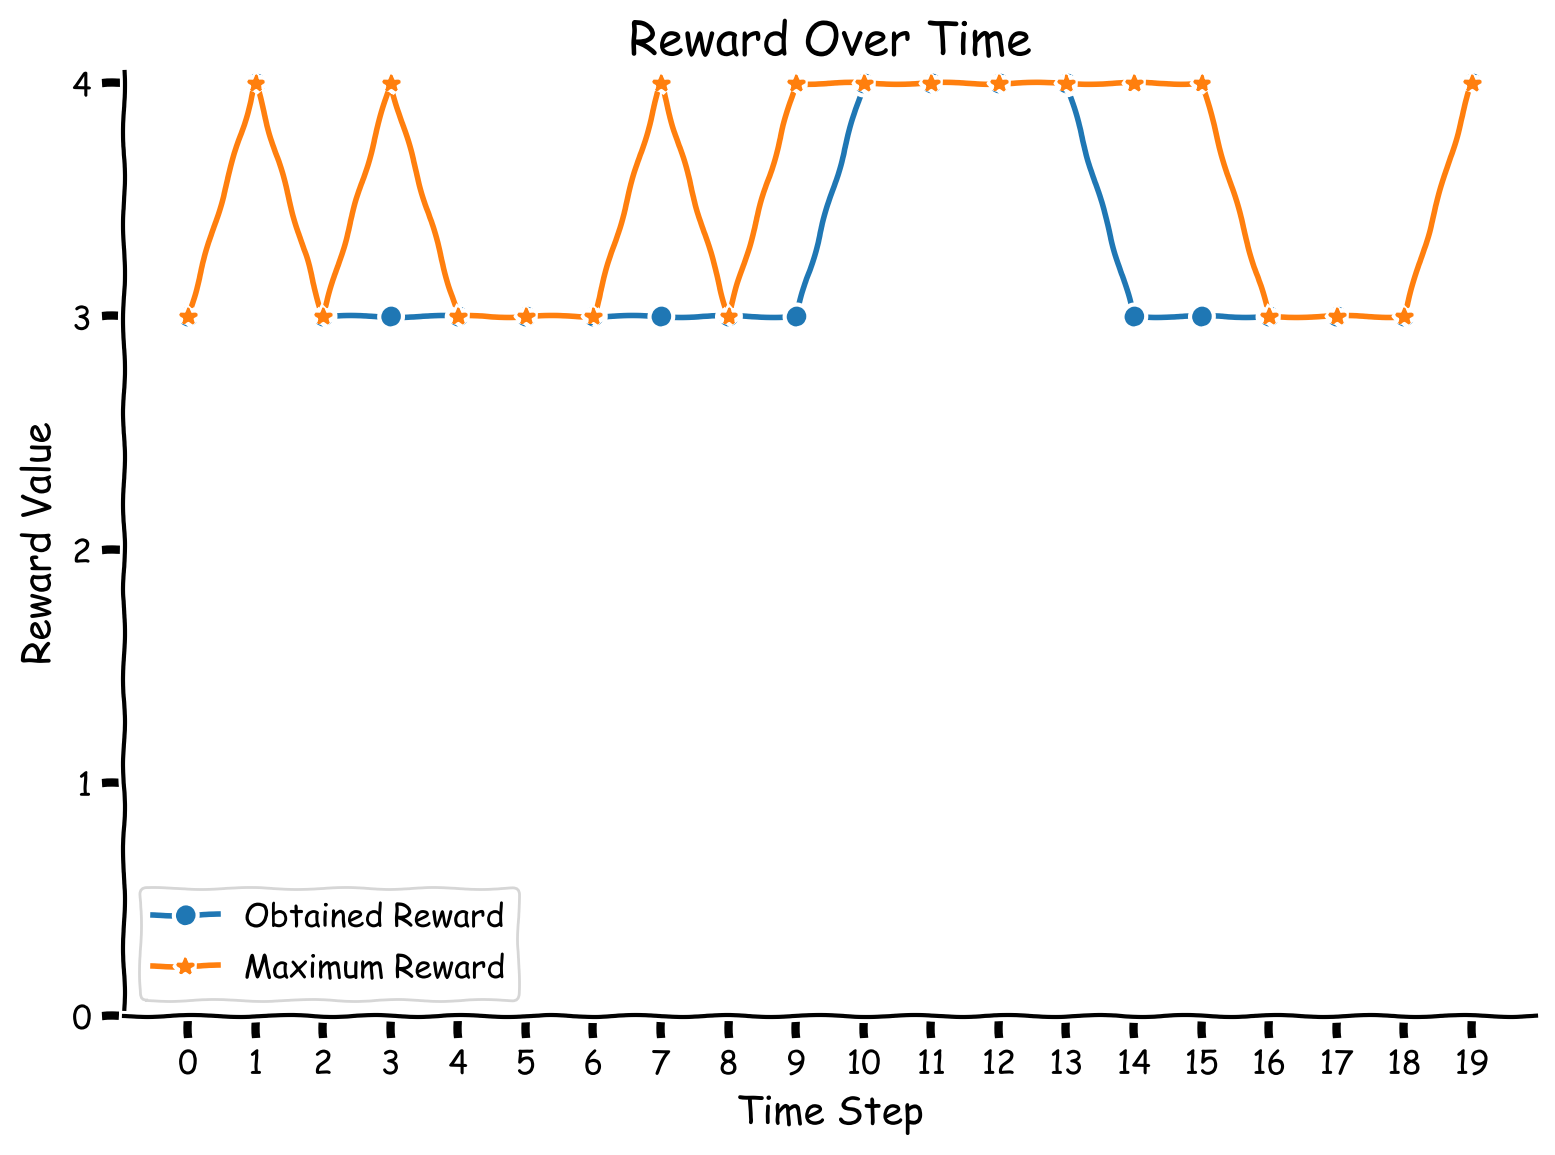

In [23]:
# @markdown Make sure you execute this cell to observe the plot!
set_seed(42)

rewards, max_rewards = evaluate_agent(env, agent, mode = 2)
plot_rewards(rewards, max_rewards)

Let's check with confusion matrix. We can see that green color is chosen often times when the blue one proporses higher reward (which the agent doesn't really know yet). 

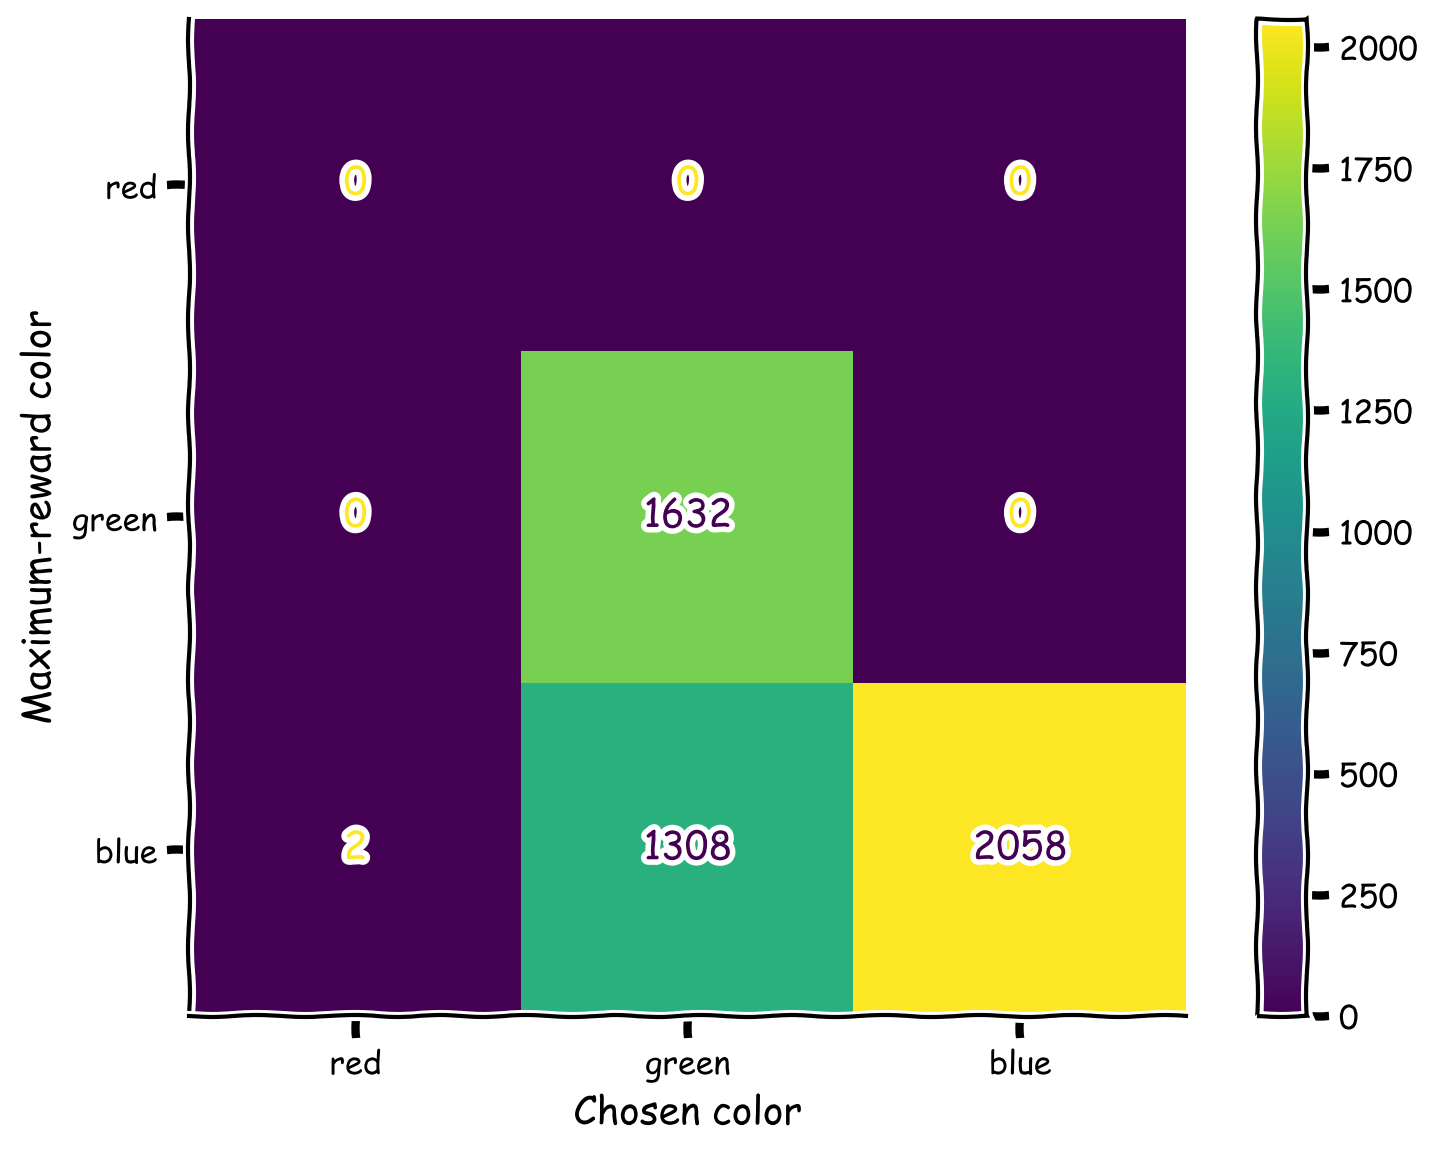

In [24]:
# @markdown Make sure you execute this cell to observe the plot!
set_seed(42)

rewards, max_rewards = evaluate_agent(env, agent, mode = 2, num_evaluation_trials = 5000)
plot_confusion_matrix(rewards, max_rewards, mode = 2)

As expected, agent doesn't know perfectly what to do with new color.

Let's continue training the same agent now in the second mode and see whether we can improve this situation. Again, you are given a pretrained agent.

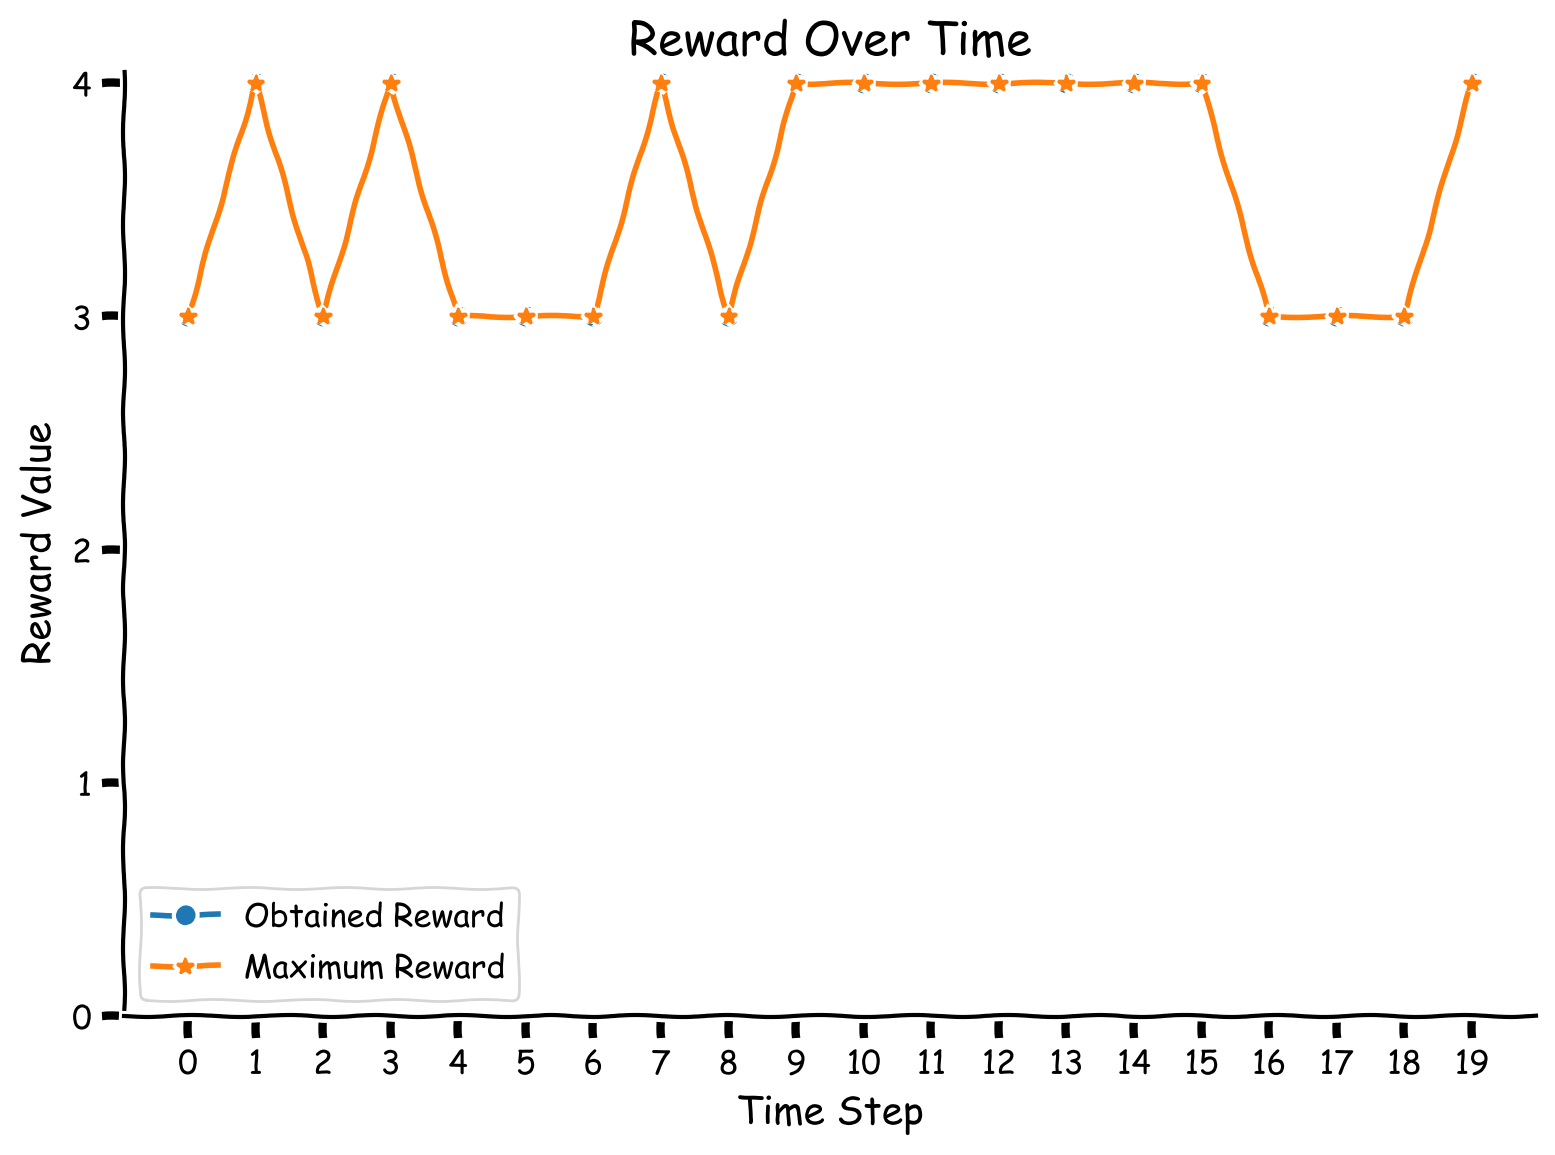

In [25]:
# @markdown Make sure you execute this cell to observe the plot!
set_seed(42)

##UNCOMMENT TO TRAIN
# env = ChangingEnv()
# optimizer_func = optim.RMSprop
# train_agent(env, agent, optimizer_func, mode = 2)
##UNCOMMENT TO TRAIN

#load agent
agent = torch.load("SecondModeAgent.pt")

rewards, max_rewards = evaluate_agent(env, agent, mode = 2)
plot_rewards(rewards, max_rewards)

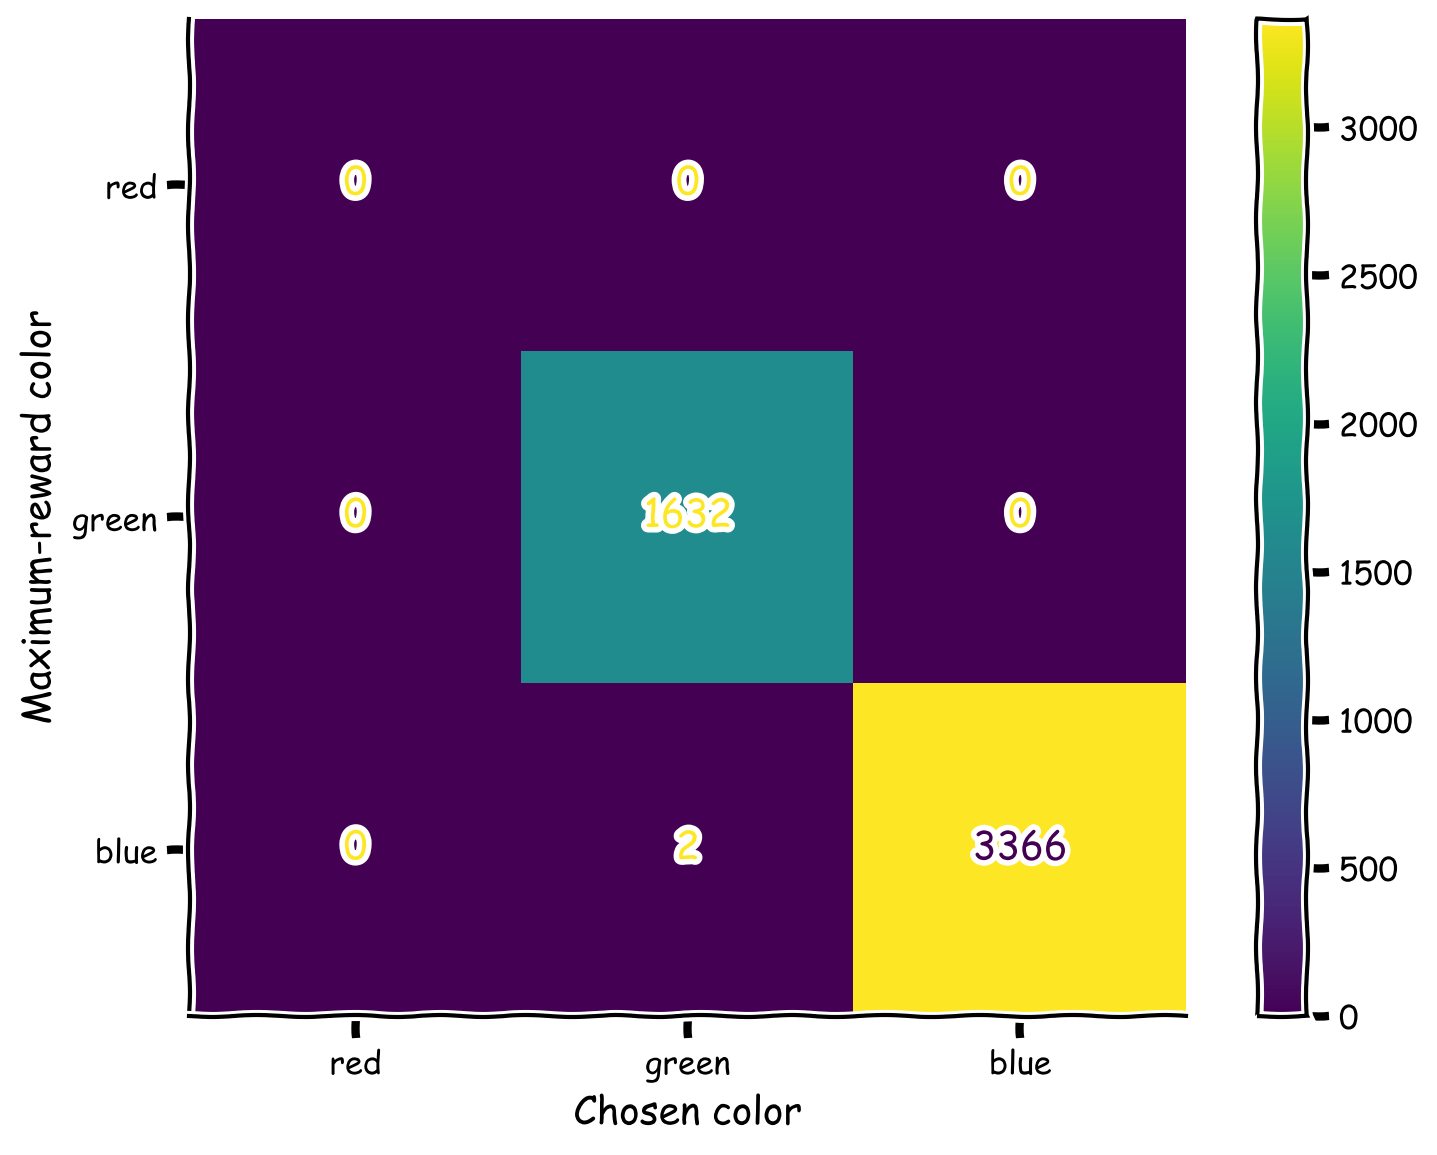

In [26]:
# @markdown Make sure you execute this cell to observe the plot!
set_seed(42)

rewards, max_rewards = evaluate_agent(env, agent, mode = 2, num_evaluation_trials = 5000)
plot_confusion_matrix(rewards, max_rewards, mode = 2)

Awesome, agent has improved its ability to perform in the second mode. Still, what about the first one? Did the agent forget the previously seen colors?

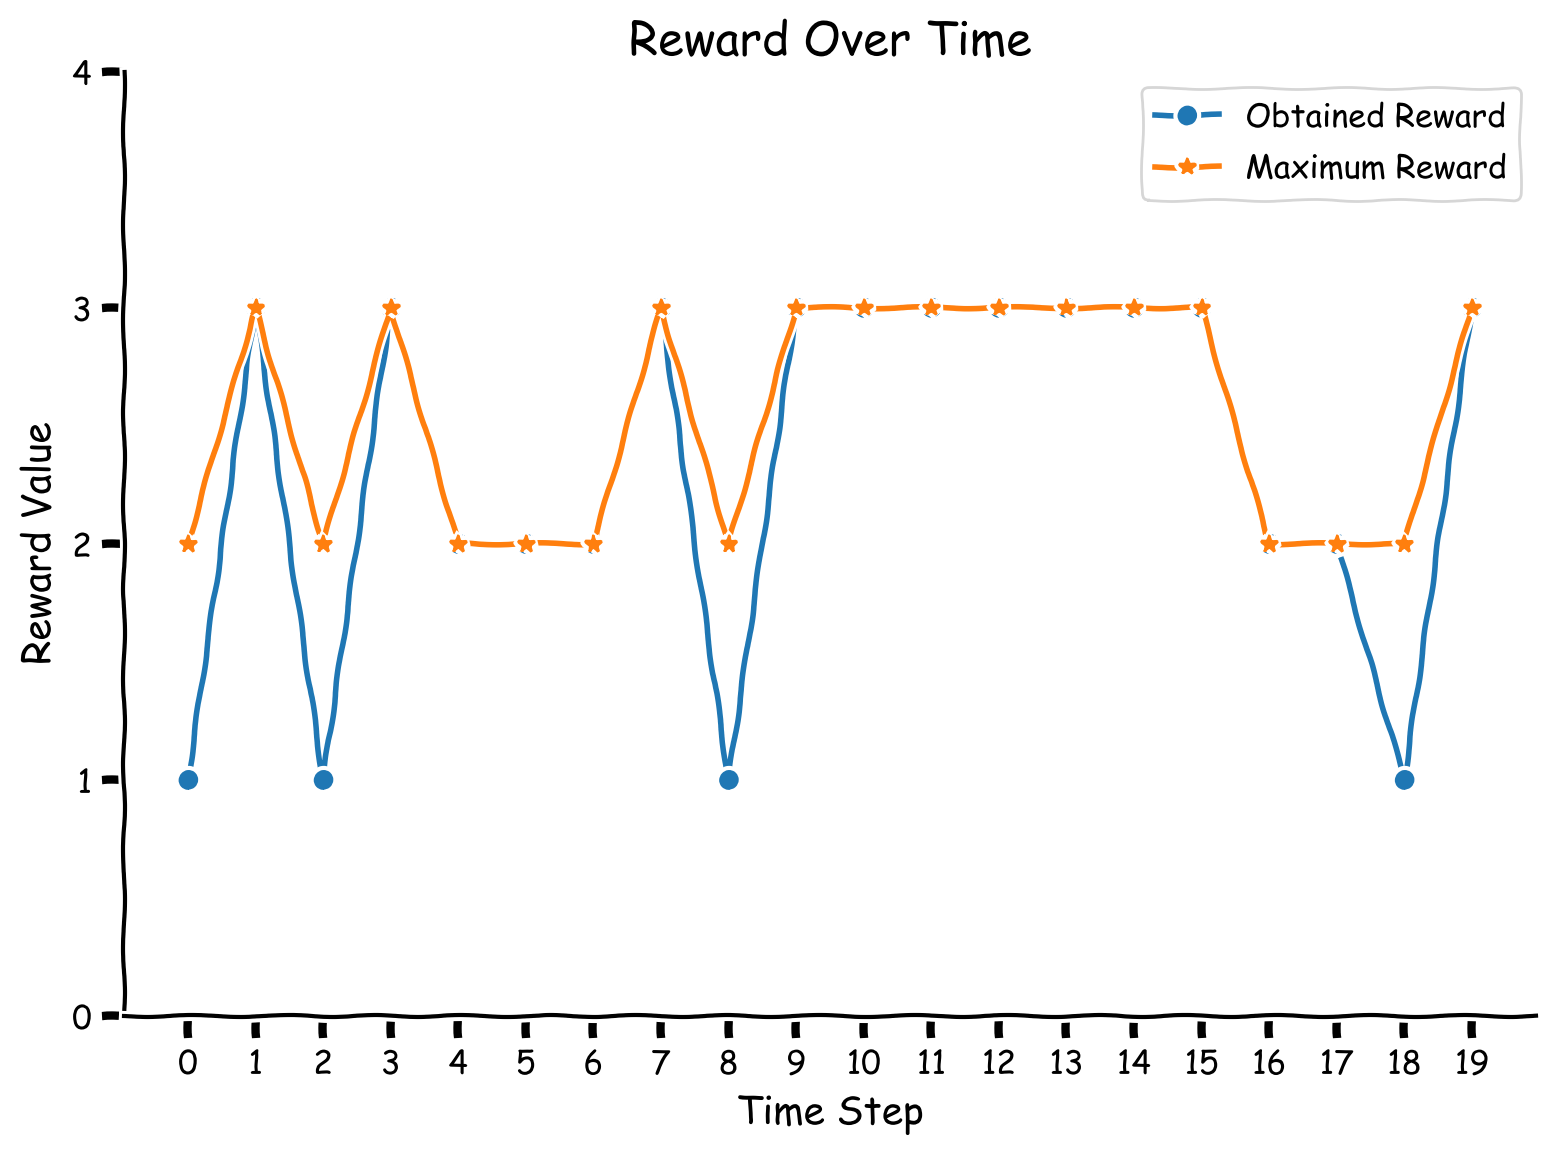

In [27]:
# @markdown Make sure you execute this cell to observe the plot!
set_seed(42)

rewards, max_rewards = evaluate_agent(env, agent, mode = 1)
plot_rewards(rewards, max_rewards)

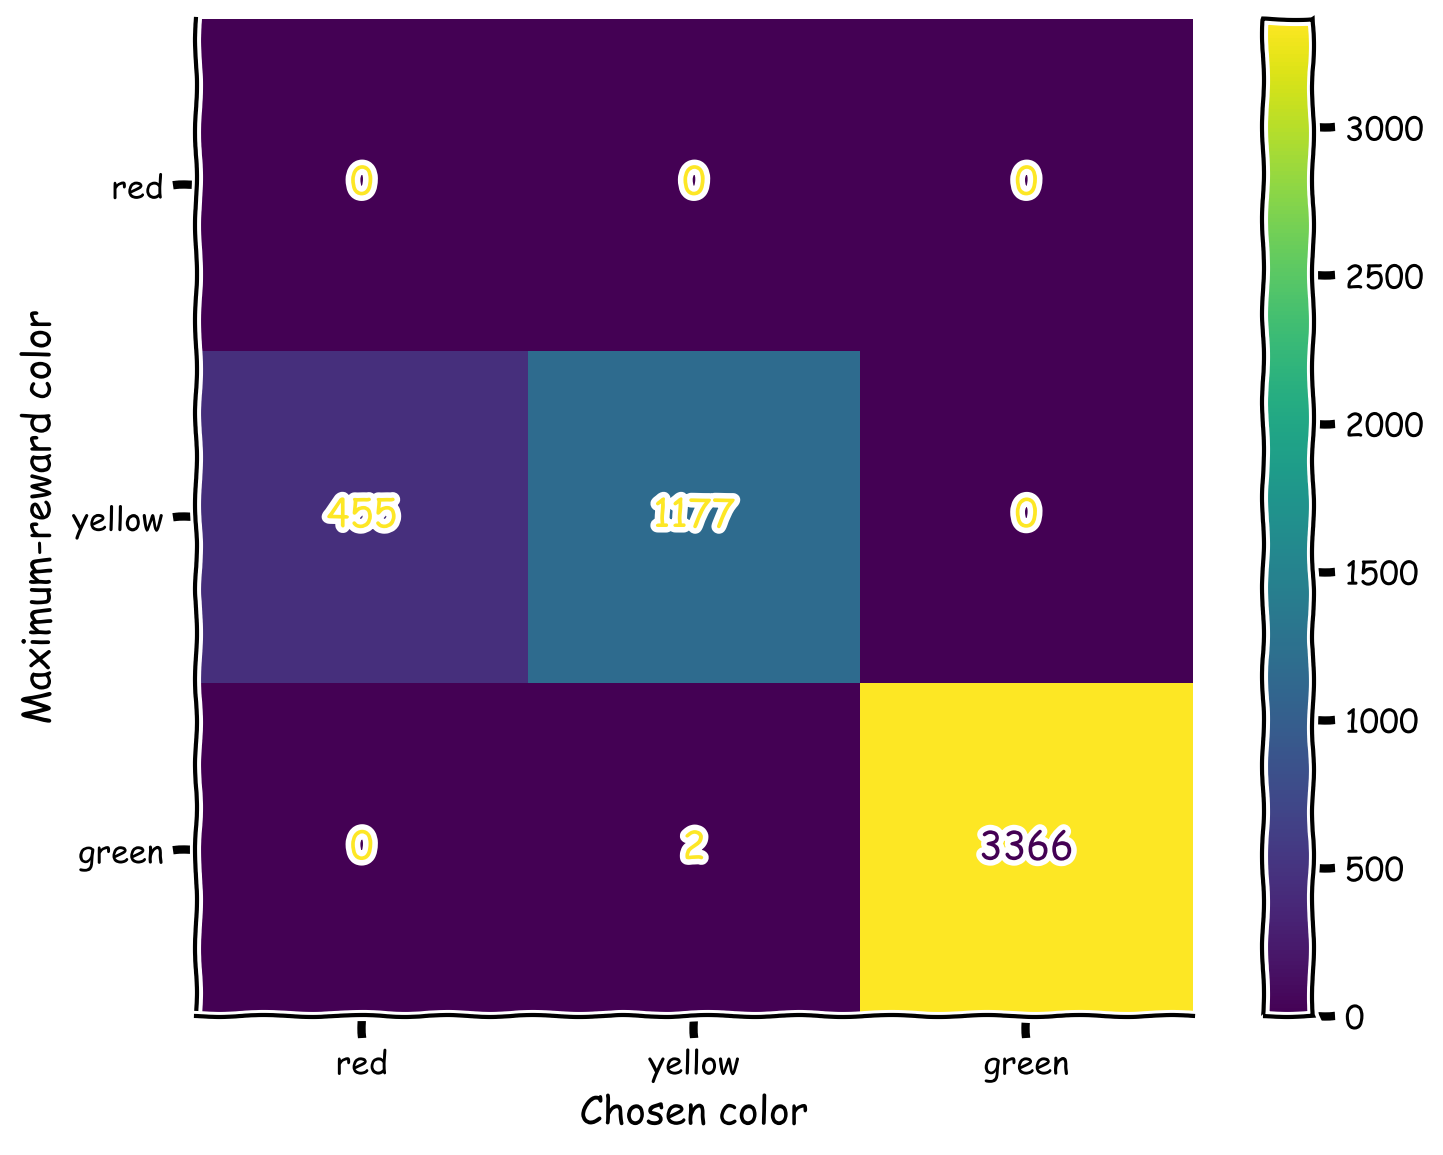

In [28]:
# @markdown Make sure you execute this cell to observe the plot!
set_seed(42)

rewards, max_rewards = evaluate_agent(env, agent, mode = 1, num_evaluation_trials = 5000)
plot_confusion_matrix(rewards, max_rewards)

Oops! Introduction of blue color in the second mode messed up learned relations between red and yellow (we didn't include yellow in the second mode). What to do? You will explore the bio-inspired mechanism which allows for correcting this behvaiour in the next section!

In [ ]:
# @title Submit your feedback
# content_review(f"{feedback_prefix}_a2c_agent_in_changing_enviornment")

---

# Section 3: Replay Buffer

*Estimated timing to here from start of tutorial: 25 minutes*

This section discusses the underlying biological reasoning behind the replay buffer as well as proposes its code implementation.

## Coding Exercise 2: Experience Again

A replay buffer is a mechanism which allows an animal to remember certain experiences within an environment, and these can be replayed in its mind during at a later time. This can be seen as akin to joint training, as it lets information from a past environment impact current learning.

goingEach of the gradient steps in the first mode is going to be "experience" we are going to save and which we will play artificially (train) during training in second mode. For that, before going to the coding part, let us take a look at the training function defined earlier - which variables do you think we need to preserve in the proposed auxiliary storage which will allow the agent to implement the replay?

The procedure for the retrieval of the past experience is the following: for each gradient step in the new mode there is going to be one gradient step on remembered experience from the previous mode.

In this exercise you need to complete `ReplayBuffer` class which will remember information about training experience. Observe that `train_agent` is redefined and slightly modified so it accepts `ReplayBuffer` instance as input.

In [29]:
class ReplayBuffer():
    def __init__(self, max_experience = 250, num_trials = 100):
        """Initialize replay buffer.
        Notice that when replay buffer is full of experience and new one should be remembered, it replaces existing ones, starting
        from the oldest.

        Inputs:
        - max_experience (int, default = 250): the maximum number of experience (gradient steps) which can be stored.
        - num_trials (int, default = 100): number of times the agent is exposed to the environment per gradient step to be trained.
        """
        self.max_experience = max_experience

        #variable which fully describe experience
        self.losses = [0 for _ in range(self.max_experience)]

        #number of memory cell to point to (write or overwrite experience)
        self.writing_pointer = 0
        self.reading_pointer = 0

        #to keep track how many experience there were
        self.num_experience = 0

    def write_experience(self, loss):
        """Write new experience."""
        ###################################################################
        ## Fill out the following then remove
        raise NotImplementedError("Student exercise: complete retrieval and storing procedure for replay buffer.")
        ###################################################################
        self.losses[...] = ...

        #so that pointer is in range of max_experience and will point to the older experience while full
        self.writing_pointer = (self.writing_pointer + 1) % self.max_experience
        self.num_experience += 1

    def read_experience(self):
        """Read existing experience."""
        loss = self.losses[...]

        #so that pointer is in range of self.max_experience and will point to the older experience while full
        self.reading_pointer = (self.reading_pointer + 1) % min(self.max_experience, self.num_experience)
        return loss

In [30]:
# to_remove solution

class ReplayBuffer():
    def __init__(self, max_experience = 250, num_trials = 100):
        """Initialize replay buffer.
        Notice that when replay buffer is full of experience and new one should be remembered, it replaces existing ones, starting
        from the oldest.

        Inputs:
        - max_experience (int, default = 250): the maximum number of experience (gradient steps) which can be stored.
        - num_trials (int, default = 100): number of times the agent is exposed to the environment per gradient step to be trained.
        """
        self.max_experience = max_experience

        #variable which fully describe experience
        self.losses = [0 for _ in range(self.max_experience)]

        #number of memory cell to point to (write or overwrite experience)
        self.writing_pointer = 0
        self.reading_pointer = 0

        #to keep track how many experience there were
        self.num_experience = 0

    def write_experience(self, loss):
        """Write new experience."""
        self.losses[self.writing_pointer] = loss

        #so that pointer is in range of max_experience and will point to the older experience while full
        self.writing_pointer = (self.writing_pointer + 1) % self.max_experience
        self.num_experience += 1

    def read_experience(self):
        """Read existing experience."""
        loss = self.losses[self.reading_pointer]

        #so that pointer is in range of self.max_experience and will point to the older experience while full
        self.reading_pointer = (self.reading_pointer + 1) % min(self.max_experience, self.num_experience)
        return loss

In [31]:
def train_agent_with_replay(env, agent, optimizer_func, replay, mode = 1, training_mode = "write", num_gradient_steps = 1000, num_trials = 100):
    """Training for agent in changing colorful environment.
    Observe that training happens for one particular mode.

    Inputs:
    - env (ChangingEnv): environment.
    - agent (ActorCritic): particular instance of Actor Critic agent to train.
    - optimizer_func (torch.Optim): optimizer to use for training.
    - replay (ReplayBuffer): replay buffer which is used during training.
    - mode (int, default = 1): mode of the environment.
    - training_mode (str, default = "write"): training mode with replay buffer ("write", "read").
    - num_gradient_steps (int, default = 1000): number of gradient steps to perform.
    - num_trials (int, default = 100): number of times the agent is exposed to the environment per gradient step to be trained.
    """
    #reset environment
    state = env.reset(mode = mode)

    #define optimizer
    optimizer = optimizer_func(agent.parameters(), agent.learning_rate, eps = 1e-5)

    for index in range(num_gradient_steps):

      #for storing variables for training
      log_probs = []
      values = []
      rewards = []
      entropy_term = torch.tensor(0.)

      #start conditions
      preceding_reward = torch.Tensor([0])
      preceding_action = torch.Tensor([0, 0])

      for trial in range(num_trials):
          #state + reward + one-hot encoding of action; notice that we normalize state before pass to agent!
          full_state = torch.cat((torch.from_numpy(state.flatten() / 255).float(), preceding_reward, preceding_action), dim = 0)
          value, policy_logits = agent(full_state)
          value = value.squeeze(0)

          #sample action from policy
          dist = torch.distributions.Categorical(logits=policy_logits.squeeze(0))
          action = dist.sample()

          #perform action to get reward and new state
          new_state, reward, _ = env.step(action)

          #we normalize reward too
          reward /= 4

          #update preceding variables
          preceding_reward = torch.Tensor([reward])
          preceding_action = F.one_hot(action, num_classes=2).float()
          state = new_state

          #for training
          log_prob = dist.log_prob(action)
          entropy = dist.entropy()
          rewards.append(reward)
          values.append(value)
          log_probs.append(log_prob)
          entropy_term += entropy

      #calculataing loss
      Qval = 0
      Qvals = torch.zeros(len(rewards))
      for t in reversed(range(len(rewards))):
        Qval = rewards[t] + agent.discount_factor * Qval
        Qvals[t] = Qval
      values = torch.stack(values)
      log_probs = torch.stack(log_probs)
      advantage = Qvals - values
      actor_loss = (-log_probs * advantage.detach()).mean()
      critic_loss = advantage.pow(2).mean()
      entropy_term = entropy_term / num_trials

      #loss incorporates actor/critic terms + entropy
      loss = actor_loss + agent.state_value_estimate_cost * critic_loss - agent.entropy_cost * entropy_term

      optimizer.zero_grad()
      loss.backward(retain_graph = True)
      optimizer.step()

      # write this training example into memory
      if training_mode == "write":
          replay.write_experience(loss)

      #retrieve previous experience
      if training_mode == "read":
          replay_loss = replay.read_experience()
          optimizer.zero_grad()
          replay_loss.backward(retain_graph = True)
          optimizer.step()

At first, we are going to train the newbie agent in the first mode using writing mode of replay buffer. Then, during the training in the second mode, we will incorporate reading from this replay buffer and observe whether it impacts agent's performance.

The training time will take around 3 minutes.

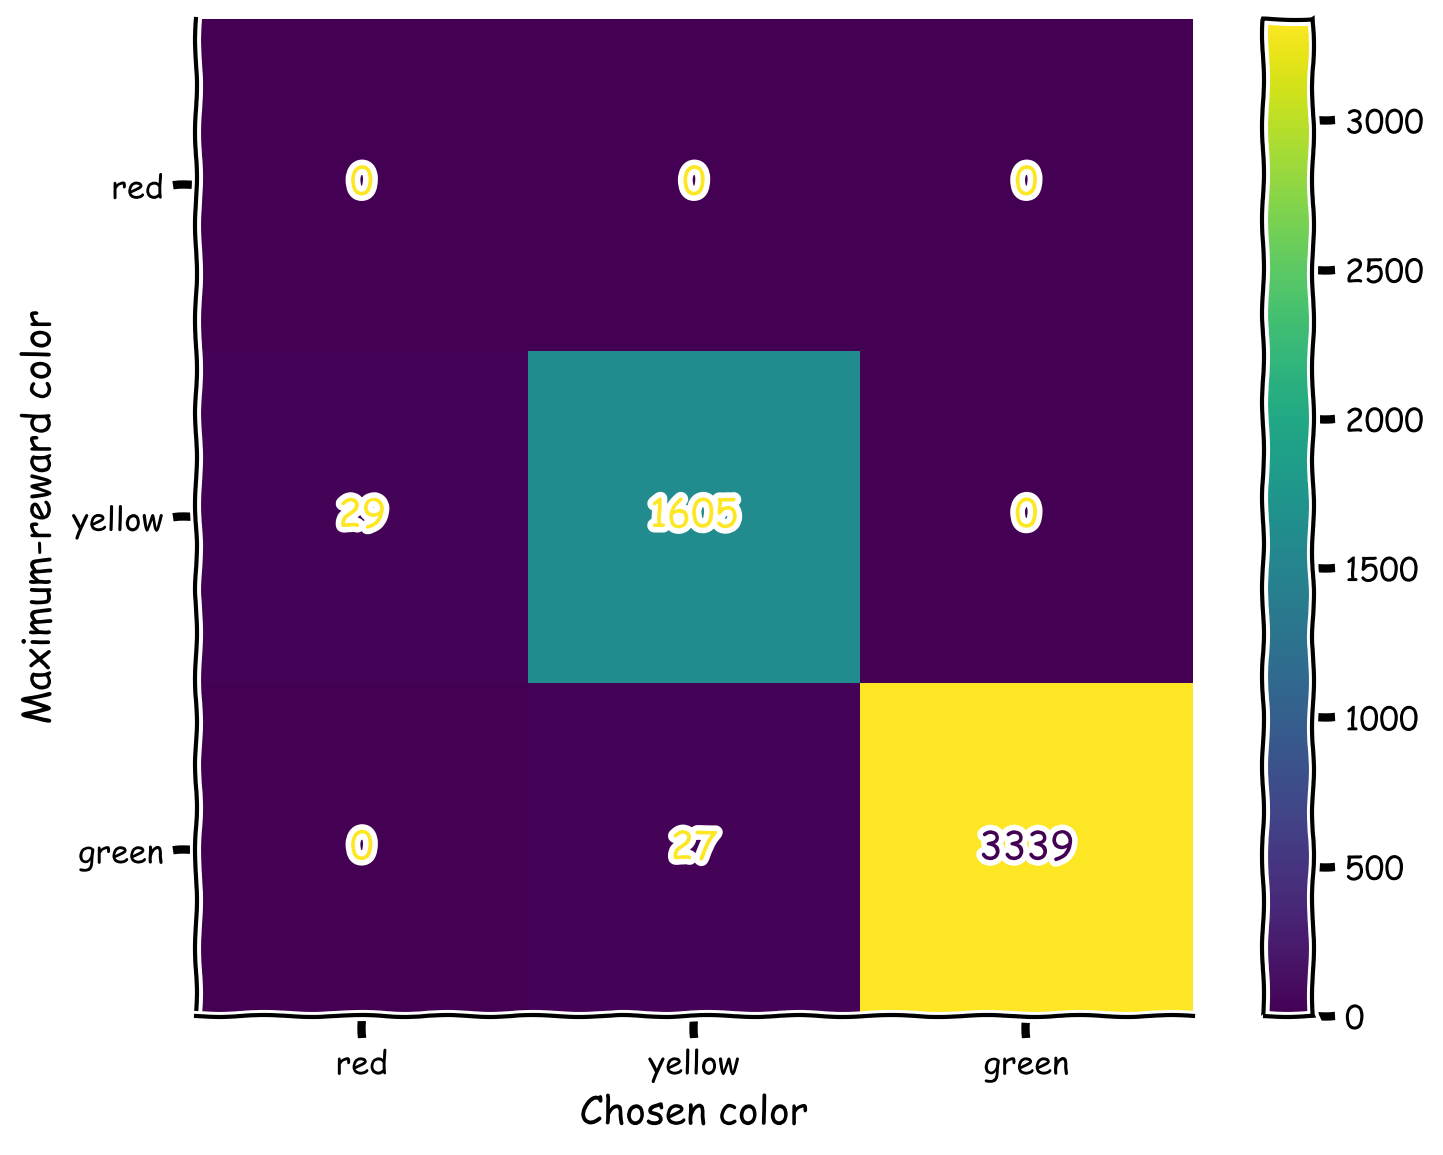

In [32]:
# @markdown Make sure you execute this cell to observe the plot!

set_seed(42)

#define environment
env = ChangingEnv()
replay = ReplayBuffer()

#define agent and optimizer
agent = ActorCritic(hidden_size = 100)
optimizer_func = optim.RMSprop

#train agent
train_agent_with_replay(env, agent, optimizer_func, replay)

rewards, max_rewards = evaluate_agent(env, agent, num_evaluation_trials = 5000)
plot_confusion_matrix(rewards, max_rewards)

Great! We've trained agent in the first mode and saved the experience in replay buffer. Now, let us change the mode to "read" and train the agent in the second mode with replaying saved experience each gradient step of the new one. The observed plot is the confusion matrix for the second mode.

In [ ]:
set_seed(42)

train_agent_with_replay(env, agent, optimizer_func, replay, mode = 2, training_mode = "read")

In [ ]:
# @markdown Make sure you execute this cell to observe the plot!
set_seed(42)

rewards, max_rewards = evaluate_agent(env, agent, mode = 2, num_evaluation_trials = 5000)
plot_confusion_matrix(rewards, max_rewards, mode = 2)

In [ ]:
# @markdown Make sure you execute this cell to observe the plot!

set_seed(42)

rewards, max_rewards = evaluate_agent(env, agent, num_evaluation_trials = 5000)
plot_confusion_matrix(rewards, max_rewards)

Perfect match!

In [ ]:
# @title Submit your feedback
# content_review(f"{feedback_prefix}_experience_again")

---
# Summary

*Estimated timing of tutorial: 40 minutes*

Here we have learned:

- Reinforcement learning also suffers from forgetting after learning on a new distribution.
- Replay is a biologically-inspired way to learn from memories of past actions and rewards, thus preventing forgetting.